# Lab 3 — recommender systems

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [1]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [4]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

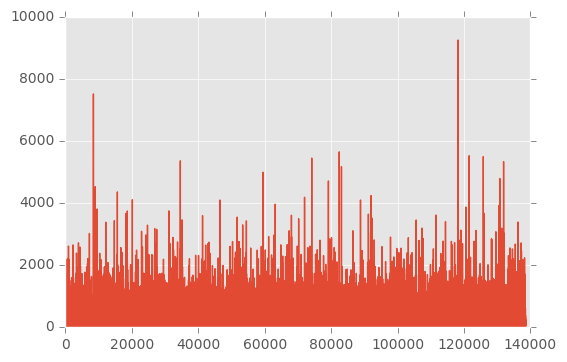

In [16]:
usersRatingCount = data.map(lambda rating: (rating['userId'],1)).countByKey().items()
plt.plot(*zip(*usersRatingCount));

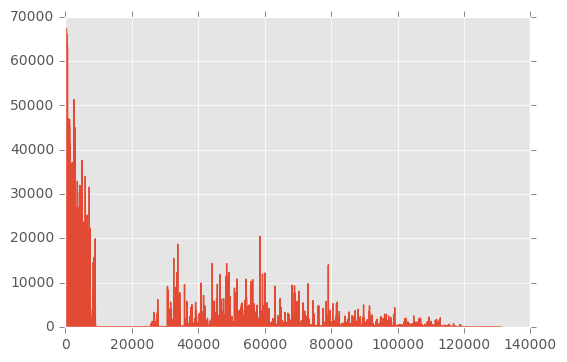

In [17]:
moviesRatingCount = sorted(data.map(lambda rating: (rating['movieId'],1)).countByKey().items())
plt.plot(*zip(*moviesRatingCount));